# Ex 12-1. House price prediction: Multi-input model

- 집 가격에 영향을 미치는 것은 무엇이 있을까?
    - 지역
    - 크기
    - 방의 개수
    - 집이 얼마나 멋진가! 
- 집 가격을 예측하기 위해 정형데이터와 이미지 데이터를 함께 사용해보도록 하자.
![](https://www.pyimagesearch.com/wp-content/uploads/2019/01/keras_regression_cnns_houses.jpg)

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.layers import Dense, Activation, Dropout, Dense, Conv2D, MaxPooling2D, Flatten, Input, concatenate
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.models import Sequential, Model
from keras.preprocessing import image

import numpy as np
import argparse
import locale
import os
import pandas as pd
import glob

Using TensorFlow backend.


## Data Preprocessing
### Structured data

In [2]:
inputPath = "data/Houses Dataset/HousesInfo.txt"
cols = ["bedrooms", "bathrooms", "area", "zipcode", "price"]
df = pd.read_csv(inputPath, sep=" ", header=None, names=cols)

In [3]:
df.head()

,bedrooms,bathrooms,area,zipcode,price
0,4,4.0,4053,85255,869500.0
1,4,3.0,3343,36372,865200.0
2,3,4.0,3923,85266,889000.0
3,5,5.0,4022,85262,910000.0
4,3,4.0,4116,85266,971226.0


In [4]:
df["zipcode"].value_counts()

92276    100
93510     60
93446     54
92880     49
94501     41
91901     32
92677     26
94531     22
85255     12
96019     12
93111     11
92021     11
85266     11
81524     11
95220     10
92802      9
85262      9
62234      7
62214      4
98021      4
85377      3
60002      3
91752      3
81418      2
62025      2
92692      2
92253      2
60016      2
93924      1
90211      1
90038      1
93314      1
90265      1
93105      1
92040      1
62249      1
95008      1
91915      1
62034      1
85331      1
94565      1
94568      1
92543      1
60046      1
62088      1
81521      1
36372      1
93720      1
90803      1
Name: zipcode, dtype: int64

- 지역(zipcode)가 몇 군데에 몰려 있음.
- 관측치가 25개보다 적은 지역은 빼고 분석을 진행하기로 함.

In [5]:
counts = df["zipcode"].value_counts()
zipcodes = counts[counts>25].keys()

In [6]:
zipcodes

Int64Index([92276, 93510, 93446, 92880, 94501, 91901, 92677], dtype='int64')

In [7]:
df = df.loc[df.zipcode.isin(zipcodes)]
df.zipcode.value_counts()

92276    100
93510     60
93446     54
92880     49
94501     41
91901     32
92677     26
Name: zipcode, dtype: int64

- zipcode를 one-hot encoding으로 변환 

In [8]:
df.zipcode = df.zipcode.astype('category')
df = pd.concat([df, pd.get_dummies(df.zipcode)], axis=1)
df = df.drop("zipcode", axis=1)

In [9]:
df.head()

,bedrooms,bathrooms,area,price,91901,92276,92677,92880,93446,93510,94501
30,5,3.0,2520,789000.0,0,0,0,0,1,0,0
32,3,2.0,1802,365000.0,0,0,0,0,1,0,0
39,3,3.0,2146,455000.0,0,0,0,0,1,0,0
80,4,2.5,2464,599000.0,1,0,0,0,0,0,0
81,2,2.0,1845,529800.0,1,0,0,0,0,0,0


- price를 제외한 나머지를 X로, price를 Y로 저장

In [10]:
X = df.drop("price", axis=1)
Y = df["price"]

### Image data

- 한 집에 대해 네 장의 사진이 아래와 같은 이름으로 저장되어 있음.

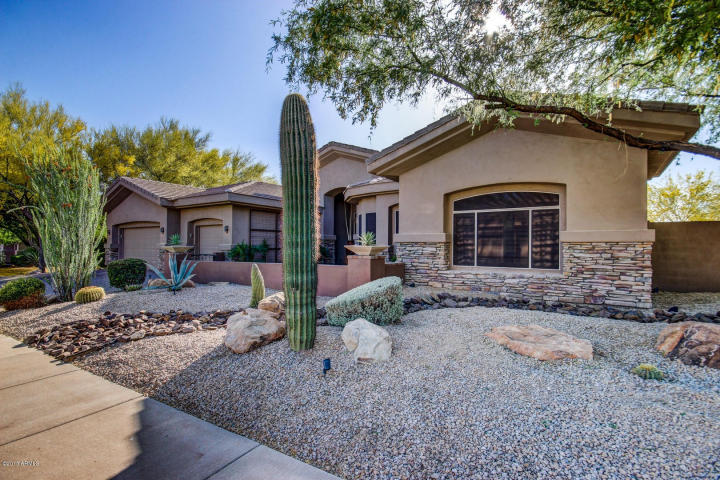

In [11]:
image.load_img("data/Houses Dataset/1_frontal.jpg")

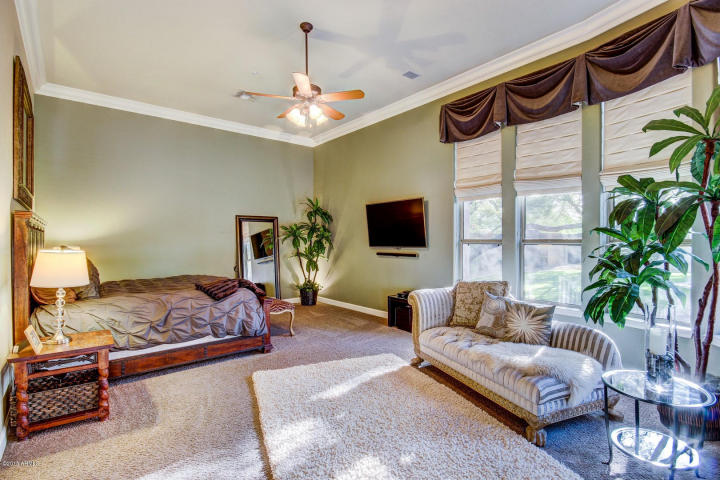

In [12]:
image.load_img("data/Houses Dataset/1_bedroom.jpg")

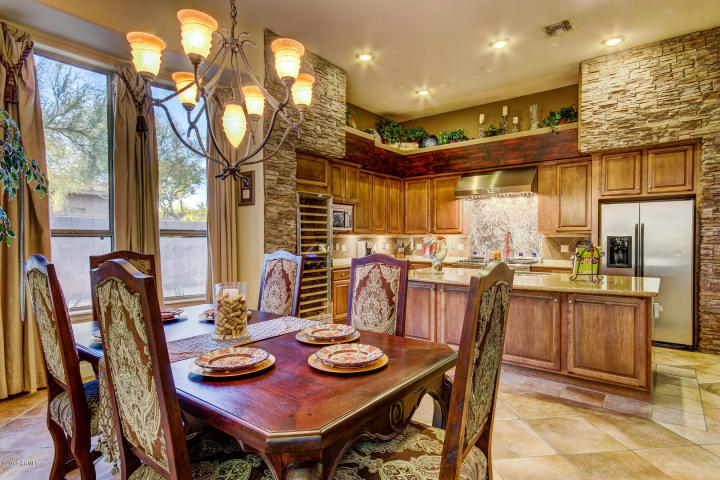

In [13]:
image.load_img("data/Houses Dataset/1_kitchen.jpg")

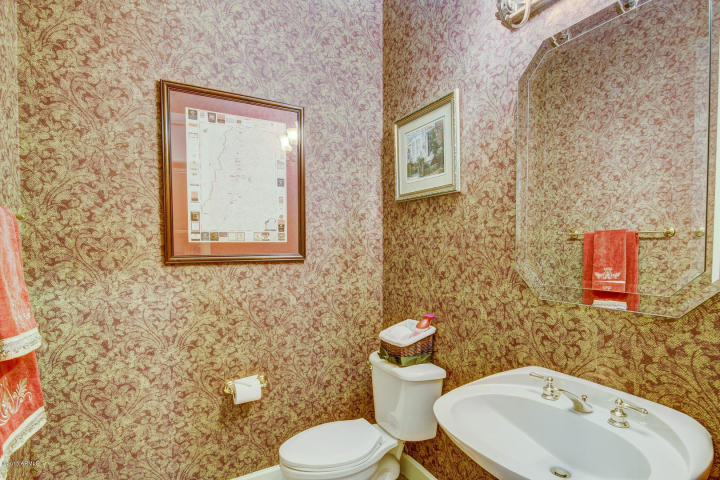

In [14]:
image.load_img("data/Houses Dataset/1_bathroom.jpg")

- 이미지를 순차적으로 불러와서 (64, 64) 픽셀로 변환
- images_bathroom, images_bedroom, images_frontal, images_kitchen의 이름으로 각 종류의 이미지를 np.array로 모아서 저장

In [15]:
input_path = "data/Houses Dataset"

img_names = ["bathroom", "bedroom", "frontal", "kitchen"]
for i, name in enumerate(img_names):
    exec("images_%s = []" % name)

In [16]:
images_bathroom

[]

In [18]:
df.head()

,bedrooms,bathrooms,area,price,91901,92276,92677,92880,93446,93510,94501
30,5,3.0,2520,789000.0,0,0,0,0,1,0,0
32,3,2.0,1802,365000.0,0,0,0,0,1,0,0
39,3,3.0,2146,455000.0,0,0,0,0,1,0,0
80,4,2.5,2464,599000.0,1,0,0,0,0,0,0
81,2,2.0,1845,529800.0,1,0,0,0,0,0,0


In [19]:
i=1
basePath = os.path.sep.join([input_path, "{}_*".format(i + 1)])
housePaths = sorted(list(glob.glob(basePath)))

In [20]:
housePaths

['data/Houses Dataset/2_bathroom.jpg',
 'data/Houses Dataset/2_bedroom.jpg',
 'data/Houses Dataset/2_frontal.jpg',
 'data/Houses Dataset/2_kitchen.jpg']

In [22]:
for i in df.index.values:
    basePath = os.path.sep.join([input_path, "{}_*".format(i + 1)])
    housePaths = sorted(list(glob.glob(basePath)))
    inputImages = []
    for housePath in housePaths:
        img = image.load_img(housePath, target_size=(64, 64))
        x = image.img_to_array(img)
        x = x/225.
        inputImages.append(x)
    
    for j, name in enumerate(img_names):
        exec("images_%s.append(inputImages[%d])" % (name, j))
    

In [23]:
len(images_bathroom)

362

In [25]:
images_bathroom[0].shape

(64, 64, 3)

## Train/test split

- train, test set으로 나누고 np.array로 변환

In [26]:
from sklearn.model_selection import train_test_split
split = train_test_split(X, Y, images_bathroom, images_bedroom, images_frontal, images_kitchen, 
                         test_size=0.25, random_state=10)

In [27]:
len(split)

12

In [28]:
var_names = ["X", "Y", "bathroom", "bedroom", "frontal", "kitchen"]
for i, name in enumerate(var_names):
    exec("train_%s = np.array(split[%d])" % (name, 2*i))
    exec("test_%s = np.array(split[%d])" % (name, 2*i+1))

In [29]:
train_X.shape, train_Y.shape, train_bathroom.shape

((271, 10), (271,), (271, 64, 64, 3))

## Transformation

- X에 대해 train set을 기준으로 min-max transformation 적용

In [30]:
scaler = MinMaxScaler()
train_X = scaler.fit_transform(train_X)
test_X = scaler.transform(test_X)

- Y는 최대 가격을 기준으로 0-1 사이의 값으로 변환

In [31]:
maxprice = train_Y.max()
train_Y /= maxprice
test_Y /= maxprice

## Construct Models

- 16개의 node를 가진 두 개의 dense layer를 포함하는 모형을 만들고자 한다. (16,16)을 입력으로 받아 for loop와 keras functional API를 사용하여 자동화 하는 코드를 작성해보자.

In [33]:
inputs = Input(shape=(5,))
nodes = (16, 16, 16)
for (i, f) in enumerate(nodes):
    if i==0:
        x = inputs
    x = Dense(f, activation="relu")(x)
model = Model(inputs, x)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 5)                 0         
_________________________________________________________________
dense_3 (Dense)              (None, 16)                96        
_________________________________________________________________
dense_4 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_5 (Dense)              (None, 16)                272       
Total params: 640
Trainable params: 640
Non-trainable params: 0
_________________________________________________________________


<font color=blue>

TO DO: 아래의 사항을 반영하여 DNN 모형을 만드는 함수를 완성하시오. 
- input layer의 shape을 `dim`으로 입력받음.
- 각 dense layer의 node의 개수를 tuple형식으로 `nodes`로 입력받음.
- 각 layer의 activation은 "relu"로 고정


In [36]:
def create_mlp(dim, nodes=(8,4)):
    inputs = Input(shape=(dim,))
    for (i, f) in enumerate(nodes):
        if i == 0:
            x = inputs
        x = Dense(f, activation="relu")(x)
    model = Model(inputs, x)
    return model

In [38]:
model = create_mlp(10, (16, 8, 4))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 10)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 16)                176       
_________________________________________________________________
dense_12 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_13 (Dense)             (None, 4)                 36        
Total params: 348
Trainable params: 348
Non-trainable params: 0
_________________________________________________________________


In [40]:
model.output

<tf.Tensor 'dense_13/Relu:0' shape=(?, 4) dtype=float32>

<font color=blue>

TO DO: 아래의 사항을 반영하여 CNN 모형을 만드는 함수를 완성하시오. 
- input layer의 shape을 `inputshape`으로 tuple 형태를 입력받음.
- 각 Convolution layer의 filter의 수를 `filters`로 tuple 형태를 입력받음.
- 각 `Conv2D` layer 뒤에 (2,2)를 사용한 maxpooling layer를 연결함.
- `filters`에 입력된 만큼의 Conv-Maxpooling layer를 쌓은 뒤 아래의 layer를 연결함.
    - Flatten
    - Dense(16)
    - Dropout(0.5)
    - Dense(4)

In [41]:
def create_cnn(inputshape, filters=(16, 32)):
    inputs = Input(shape=inputshape)

    for (i, f) in enumerate(filters):
        if i == 0:
            x = inputs
        x = Conv2D(f, (3, 3), padding="same", activation="relu")(x)
        x = MaxPooling2D((2, 2))(x)
        
    x = Flatten()(x)
    x = Dense(16, activation="relu")(x)
    x = Dropout(0.5)(x)
    x = Dense(4, activation="relu")(x)
    model = Model(inputs, x)
    return model

In [42]:
model = create_cnn((32,32,3), filters=(8, 16, 32))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 8)         224       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 16)        1168      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 16)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 32)          4640      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 4, 4, 32)          0         
__________

## (1) DNN model 

<font color=blue>
    
TO DO: 위에서 작성한 `create_mlp` 함수를 사용하여 `train_X`를 input으로, `train_Y`를 output으로 하는 DNN 모형을 만드시오.  8, 4의 hidden nodes를 가지는 hidden layer를 포함하도록 만드시오. 

In [55]:
mlp_model = create_mlp(train_X.shape[1])
x = Dense(1)(mlp_model.output)
model1 = Model(inputs=mlp_model.input, outputs=x)

In [56]:
model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 10)                0         
_________________________________________________________________
dense_25 (Dense)             (None, 8)                 88        
_________________________________________________________________
dense_26 (Dense)             (None, 4)                 36        
_________________________________________________________________
dense_27 (Dense)             (None, 1)                 5         
Total params: 129
Trainable params: 129
Non-trainable params: 0
_________________________________________________________________


<font color=blue>
    
TO DO: 위에서 만든 모형을 훈련하시오. 
- `train_X, train_Y`을 train set으로 사용 
- `test_X, test_Y`를 validation set으로 사용
- epoch=100
- batch size=8
- adam optimizer 사용
- 훈련 시  mae(mean absolute error)를 함께 모니터
- 훈련 과정의 loss를 확인하기 위해 model.fit을 `history`이름으로 저장

In [57]:
model1.compile(loss="mse", optimizer="adam", metrics = ["mae"])
history = model1.fit(train_X, train_Y,
          validation_data=(test_X, test_Y), epochs=100, batch_size=8)

Train on 271 samples, validate on 91 samples
Epoch 1/100
271/271 [==============================] - 0s 1ms/step - loss: 0.0980 - mean_absolute_error: 0.2488 - val_loss: 0.0443 - val_mean_absolute_error: 0.1700
Epoch 2/100
271/271 [==============================] - 0s 329us/step - loss: 0.0395 - mean_absolute_error: 0.1597 - val_loss: 0.0182 - val_mean_absolute_error: 0.1157
Epoch 3/100
271/271 [==============================] - 0s 300us/step - loss: 0.0219 - mean_absolute_error: 0.1167 - val_loss: 0.0106 - val_mean_absolute_error: 0.0887
Epoch 4/100
271/271 [==============================] - 0s 286us/step - loss: 0.0143 - mean_absolute_error: 0.0895 - val_loss: 0.0068 - val_mean_absolute_error: 0.0702
Epoch 5/100
271/271 [==============================] - 0s 266us/step - loss: 0.0108 - mean_absolute_error: 0.0718 - val_loss: 0.0050 - val_mean_absolute_error: 0.0590
Epoch 6/100
271/271 [==============================] - 0s 262us/step - loss: 0.0091 - mean_absolute_error: 0.0629 - val_lo

271/271 [==============================] - 0s 278us/step - loss: 0.0050 - mean_absolute_error: 0.0301 - val_loss: 0.0016 - val_mean_absolute_error: 0.0282
Epoch 50/100
271/271 [==============================] - 0s 273us/step - loss: 0.0050 - mean_absolute_error: 0.0314 - val_loss: 0.0015 - val_mean_absolute_error: 0.0268
Epoch 51/100
271/271 [==============================] - 0s 276us/step - loss: 0.0050 - mean_absolute_error: 0.0298 - val_loss: 0.0014 - val_mean_absolute_error: 0.0259
Epoch 52/100
271/271 [==============================] - 0s 285us/step - loss: 0.0049 - mean_absolute_error: 0.0305 - val_loss: 0.0017 - val_mean_absolute_error: 0.0284
Epoch 53/100
271/271 [==============================] - 0s 266us/step - loss: 0.0050 - mean_absolute_error: 0.0302 - val_loss: 0.0016 - val_mean_absolute_error: 0.0280
Epoch 54/100
271/271 [==============================] - 0s 269us/step - loss: 0.0049 - mean_absolute_error: 0.0304 - val_loss: 0.0016 - val_mean_absolute_error: 0.0272
Epoch

Epoch 98/100
271/271 [==============================] - 0s 279us/step - loss: 0.0045 - mean_absolute_error: 0.0264 - val_loss: 0.0012 - val_mean_absolute_error: 0.0240
Epoch 99/100
271/271 [==============================] - 0s 292us/step - loss: 0.0045 - mean_absolute_error: 0.0277 - val_loss: 0.0011 - val_mean_absolute_error: 0.0236
Epoch 100/100
271/271 [==============================] - 0s 302us/step - loss: 0.0045 - mean_absolute_error: 0.0269 - val_loss: 0.0012 - val_mean_absolute_error: 0.0245


In [58]:
min(history.history['val_mean_absolute_error'])*maxprice, min(history.history['val_loss'])

(132858.3789756419, 0.0010468243073753932)

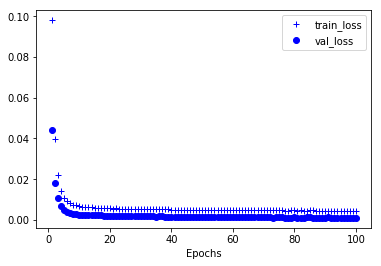

In [59]:
import matplotlib.pyplot as plt

epochs = range(1, 101)
train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(epochs, train_loss, 'b+', label='train_loss')
plt.plot(epochs, val_loss, 'bo', label='val_loss')
plt.xlabel('Epochs')
plt.legend()

plt.show()

## (2) CNN model 

<font color=blue>
    
TO DO: 
- 위에서 작성한 `create_cnn` 함수를 사용하여 bathroom, bedroom, frontal, test_kitchen의 각 사진들을 input으로 받는 4 개의 개별적인 CNN 모형을 만드시오.  
- 위에서 만들어진 4개의 모형의 output을 `concatenate` layer로 묶으시오. 
- 4개의 node를 가진 dense layer를 추가하고 output layer를 추가하여 가격을 예측하는 모형을 만드시오. 

In [ ]:
cnn_model1 = 
cnn_model2 = 
cnn_model3 = 
cnn_model4 = 

# Your answer comes here










<font color=blue>
    
TO DO: 위에서 만든 모형을 훈련하시오. 
- 4개의 집 공간에 대한 train 이미지들을 입력으로 사용
- test 이미지와 Y를 validation set으로 사용 
- epoch=100
- batch size=8
- adam optimizer 사용
- 훈련 시  mae(mean absolute error)를 함께 모니터
- 훈련 과정의 loss를 확인하기 위해 model.fit을 `history`이름으로 저장

In [ ]:
# Your answer comes here












In [ ]:
min(history.history['val_mean_absolute_error'])*maxprice, min(history.history['val_loss'])

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, 101)
train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(epochs, train_loss, 'b+', label='train_loss')
plt.plot(epochs, val_loss, 'bo', label='val_loss')
plt.xlabel('Epochs')
plt.legend()

plt.show()

## (3) DNN + CNN


<font color=blue>
    
TO DO: 
- (1)의 DNN 모형,  (2)의 네 개의 CNN 모형을 동일하게 만드시오 
- 위에서 만들어진 5개의 모형의 output을 `concatenate` layer로 묶으시오. 
- 4개의 node를 가진 dense layer를 추가하고 output layer를 추가하여 가격을 예측하는 모형을 만드시오. 
- (1), (2)와 같이 모형을 훈련하시오.

In [ ]:
# your answer comes here



















In [ ]:
min(history.history['val_mean_absolute_error'])*maxprice, min(history.history['val_loss'])

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, 101)
train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(epochs, train_loss, 'b+', label='train_loss')
plt.plot(epochs, val_loss, 'bo', label='val_loss')
plt.xlabel('Epochs')
plt.legend()

plt.show()